# 1. Exoplanet characterisation based on a single light curve

## Introduction

This is a first part of a set of tutorials covering (Bayesian) exoplanet characterisation using wide-band photometry (transit light curves), radial velocities, and, later, transmission spectroscopy. The tutorials use freely available open source tools built around the scientific python ecosystem.

The tutorials are mainly targeted to graduate students working in exoplanet characterisation with already some experience of Python, Bayesian statistics. Even then, older grad-students and young postdocs might hopefully find these useful as well.

The whole set of tutorials will be available from the [Stars & Planets @ Oxford (SPLOX)](http://splox.net/) site and [github](https://github.com/hpparvi/exo_tutorials), and the latest version of this tutorial can also be read online using [nbviewer](http://nbviewer.ipython.org/github/hpparvi/exo_tutorials/blob/master/01_broadband_parameter_estimation.ipynb).

## Prerequisites

This tutorial requires the basic Python packages for scientific computing and data analysis
- NumPy, SciPy, IPython, PyFITS, pandas, matplotlib, and [seaborn](http://stanford.edu/~mwaskom/software/seaborn/)

*Note:* The current Seaborn development version (0.16) fails to reproduce the plots without some tweaking, you'd better stick with the stable 0.15 for now.

The MCMC sampling requires the [*emcee*](https://github.com/dfm/emcee) and [acor](https://github.com/dfm/acor) packages by D. Foreman-Mackey. These can either be installed from github or from [PyPI](https://pypi.python.org/pypi).

And the rest of the analysis requires the [PyTransit](https://github.com/hpparvi/PyTransit), [PyExoTK](https://github.com/hpparvi/PyExoTK) and [PyDE](https://github.com/hpparvi/PyDE) by the author. These three can be installed easily from github. First ``cd`` into the directory you want to clone the code, and then

    git clone https://github.com/hpparvi/PyDE.git; cd PyDE    
    python setup.py config_fc --fcompiler=gnu95 --opt="-Ofast" --f90flags="-cpp -fopenmp" build
    python setup.py install --user; cd -

    git clone https://github.com/hpparvi/PyTransit.git; cd PyTransit
    python setup.py config_fc --fcompiler=gnu95 --opt="-Ofast" --f90flags="-cpp -fopenmp" build
    python setup.py install --user; cd -
    
    git clone https://github.com/hpparvi/PyExoTK.git; cd PyExoTK
    python setup.py config_fc --fcompiler=gnu95 --opt="-Ofast" --f90flags="-cpp -fopenmp" build
    python setup.py install --user; cd -
    
Assuming you have GFortran as your default Fortran compiler and have GCC >= 4.8. If not, you may need to change the ``-Ofast`` optimization flag to ``-O3``.

What comes to assumed prior knowledge, well... I assume you already know a bit about Bayesian statistics (I'll start with a very rough overview of the basics of Bayesian parameter estimation, though), Python (and especially the scientific packages), have a rough idea of MCMC sampling (and how *emcee* works), and, especially, have the grasp of basic concepts of exoplanets, transits, and photometry.

## Bayesian parameter estimation

This first tutorial covers the simple case of an exoplanet system characterisation based on a single photometric timeseries of an exoplanet transit (transit light curve). The system characterisation is a *parameter estimation* problem, where we assume we have an adequate model to describe the observations, and we want to infer the model parameters with their uncertainties.

We take a [*Bayesian*](http://en.wikipedia.org/wiki/Bayesian_probability) approach to the parameter estimation, where we want to estimate the [*posterior probability*](http://en.wikipedia.org/wiki/Posterior_probability) for the model parameters given their [*prior probabilities*](http://en.wikipedia.org/wiki/Prior_probability) and a set of observations. The posterior probability density given a parameter vector $\theta$ and observational data $D$ is described by the [*Bayes' theorem*](http://en.wikipedia.org/wiki/Bayes%27_theorem) as

$$
P(\theta|D) = \frac{P(\theta) P(D|\theta)}{P(D)}, \qquad P(D|\theta) = \prod P(D_i|\theta),
$$

where $P(\theta)$ is the prior, $P(D|\theta)$ is the [*likelihood*](http://en.wikipedia.org/wiki/Likelihood_function) for the data, and $P(D)$ is a [*normalising factor*](http://en.wikipedia.org/wiki/Marginal_likelihood) we don't need to bother with during MCMC-based parameter estimation. 

The likelihood is a product of individual observation probabilities, and has the unfortunate tendency to end up being either very small or very big. This causes computational headaches, and it is better to work with log probabilities instead, so that

$$
\log P(\theta|D) = \log P(\theta) + \log P(D|\theta),  \qquad \log P(D|\theta) = \sum \log P(D_i|\theta)
$$

where we have omitted the $P(D)$ term from the posterior density.

Now we still need to decide our likelihood density. If we can assume normally distributed white noise--that is, the errors in the observations are independent and identically distributed--we end up with a log likelihood function

$$
 \log P(D|\theta) = -N\log(\sigma) -\frac{N\log 2\pi}{2} - \sum_{i=0}^N \frac{(o_i-m_i)^2}{2\sigma^2},
$$

where $N$ is the number of datapoints, $\sigma$ is the white noise standard deviation, $o$ is the observed data, and $m$ is the model. 

*Note:* Unfortunately, the noise is rarely white, but contains systematic components from instrumental and astrophysical sources that should be accounted for by the noise model for robust parameter estimation. This, however, goes beyond a basic tutorial.

## Implementation

### Initialisation

In [1]:
%pylab inline 

import math as mt
import pyfits as pf
import seaborn as sb
import pandas as pd
import random

from os.path import join
from IPython.display import HTML
from IPython.html.widgets import IntProgressWidget, FloatProgressWidget

from pytransit.orbits_f import orbits as of
from pytransit import MandelAgol as MA

from exotk.de import DiffEvol
from exotk.priors import PriorSet, UP, NP, JP
from exotk.utils.orbits import as_from_rhop
from exotk.utils.likelihood import ll_normal_es

from emcee import EnsembleSampler
cp = sb.color_palette()

random.seed(0)

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


### Log posterior function

The log posterior function is the workhorse of the analysis. I implement it as a callable class that stores the observation data and the priors, and contains the methods to calculate the model and to evaluate the log posterior probability density.

In [2]:
class LPFunction(object):
    """A simple log posterior function class.
    """
    def __init__(self, time, flux, nthreads=2):
        self.tm = MA(lerp=True, klims=(0.08,0.13), nthr=nthreads) 
        self.nthr = nthreads

        self.time     = time.copy()
        self.flux_o   = flux.copy()
        self.npt      = flux.size
        self._wrk_lc  = zeros_like(time)  # These two work arrays are actually rather pointless
        self._wrk_ld  = zeros(2)          #
        
        self.priors = [NP(  1.01,   0.02,  'tc'), ##  0  - Transit centre
                       NP(  2.50,   0.01,   'p'), ##  1  - Period
                       JP( 0.007,  0.015,  'k2'), ##  2  - planet-star area ratio
                       NP(  1.50,    0.1, 'rho'), ##  3  - Stellar density
                       UP(     0,   0.99,   'b'), ##  4  - Impact parameter
                       UP(  1e-4,  15e-4,   'e'), ##  5  - White noise std
                       NP(   1.0,   0.01,   'c'), ##  6  - Baseline constant
                       UP(     0,    1.0,  'q1'), ##  7  - limb darkening q1
                       UP(     0,    1.0,  'q2')] ##  8  - limb darkening q2
        self.ps = PriorSet(self.priors)
        
        
    def compute_baseline(self, pv):
        """Simple constant baseline model"""
        self._wrk_lc.fill(pv[6])
        return self._wrk_lc

    
    def compute_transit(self, pv):
        """Transit model"""
        _a  = as_from_rhop(pv[3], pv[1])  # Scaled semi-major axis from stellar density and orbital period
        _i  = mt.acos(pv[4]/_a)           # Inclination from impact parameter and semi-major axis
        _k  = mt.sqrt(pv[2])              # Radius ratio from area ratio
        
        a,b = mt.sqrt(pv[7]), 2*pv[8]
        self._wrk_ld[:] = a*b, a*(1.-b)   # Quadratic limb darkening coefficients
        
        return self.tm.evaluate(self.time, _k, self._wrk_ld, pv[0], pv[1], _a, _i)

    
    def compute_lc_model(self, pv):
        """Combined baseline and transit model"""
        return self.compute_baseline(pv) * self.compute_transit(pv)


    def __call__(self, pv):
        """Log posterior density"""
        if any(pv < self.ps.pmins) or any(pv>self.ps.pmaxs):
            return -inf
        flux_m = self.compute_lc_model(pv)
        return self.ps.c_log_prior(pv) + ll_normal_es(self.flux_o, flux_m, pv[5])

#### Priors

The priors are contained in a list and a ``PriorSet`` object from ``exotk.priors``. The latter is a utility class containing a function for calculating the joint prior, etc. We're using three very basic priors: a normal prior ``NP``, for which $x \sim N(\mu,\sigma)$, a uniform prior ``UP``, for which $x \sim U(a,b)$, and a Jeffreys' prior ``JP``.

We could use an informative prior on the planet-star area ratio (squared radius ratio) that we base on the observed NIR transit depth (see below). This is justified since the limb darkening, which affects the observed transit depth, is sufficiently weak in NIR. We would either need to use significantly wider informative prior, or an uninformative one, if we didn't have NIR data.

#### Model

The model has two components: a multiplicative constant baseline, and a transit shape modelled using the quadratic Mandel&nbsp;&&nbsp;Agol transit model implemented in ``PyTransit``. The sampling parameterisation is different than the parameterisation used by the transit model, so we need to map the parameters from the sampling space to the model space. Also, we're keeping things simple and assuming a circular orbit. Eccentric orbits will be considered in later tutorials.  

#### Limb darkening

The **limb darkening** uses the parameterisation by [Kipping (2013, MNRAS, 435(3), 2152–2160)](http://mnras.oxfordjournals.org/content/435/3/2152), where the quadratic limb darkening coefficients $u$ and $v$ are mapped from sampling parameters $q_1$ and $q_2$ as

$$
u = 2\sqrt{q_1}q_2,
$$

$$
v = \sqrt{q_1}(1-2q_2).
$$

This parameterisation allows us to use uniform priors from 0 to 1 to cover the whole physically sensible $(u,v)$-space.

#### Log likelihood

The *log likelihood* calculation is carried out by the ``ll_normal_es`` function from ``exotk.utils.likelihood``. The routine is implemented in Fortran for efficiency, and evaluates the normal log likelihood given a single error value (the module also contains a function ``ll_normal_ev`` that takes an error estimate for each point, this will be used in a later tutorial).

### Read in the data

First we need to read in the (mock) observation data stored in ``obs_data.fits``. The data corresponds to a single transit observed simultaneously in eight passbands (filters). The photometry is saved in extension 1 as a binary table, and we want to read the mid-exposure times and flux values corresponding to different passbands. The time is stored in the ``time`` column, and fluxes are stored in the ``f_wn_*`` columns, where ``*`` is the filter name.

In [3]:
data = pf.getdata(join('data','obs_data.fits'), ext=1)

flux_keys = [n for n in data.names if 'f_wn' in n]
filter_names = [k.split('_')[-1] for k in flux_keys]

time = data['time']
fluxes = [data[k] for k in flux_keys]

print 'Filter names: ' + ', '.join(filter_names)

Filter names: u, g, r, i, z, J2, H2, Ks


First, let's have a quick look at our data, and plot the blue- and redmost passbands. 

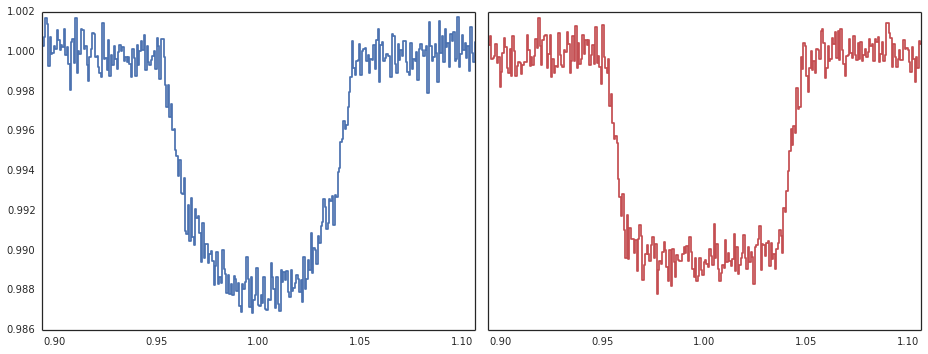

In [4]:
with sb.axes_style('white'):
    fig, axs = subplots(1,2, figsize=(13,5), sharey=True)
    axs[0].plot(time,fluxes[0], drawstyle='steps-mid', c=cp[0])
    axs[1].plot(time,fluxes[-1], drawstyle='steps-mid', c=cp[2])
    setp(axs, xlim=time[[0,-1]])
    fig.tight_layout()

Here we see what we'd expect to see. The stronger limb darkening in blue makes the bluemost transit round, while we can spot the end of ingress and the beginning of egress directly by eye from the redmost light curve. Also, the transit is deeper in *u'* than in *Ks*, which tells that the impact parameter *b* is smallish (the transit would be deeper in red than in blue for large *b*).

## Basic parameter estimation

First, we create an instance of the log posterior function (we feed it with the redmost light curve), and initialise the *DE* optimiser and the *emcee* sampler.

In [5]:
npop, de_iter, mc_iter = 100, 200, 2500
lpf = LPFunction(time, fluxes[-1])
de = DiffEvol(lpf, lpf.ps.bounds, npop, maximize=True)
sampler = EnsembleSampler(npop, lpf.ps.ndim, lpf)

Next, we run the *DE* optimiser for ``de_iter`` iterations to clump the parameter vector population close to the global posterior maximum, use the *DE* population to initialise the *emcee* sampler, and run the sampler for ``mc_iter`` iterations to obtain a posterior sample. The MCMC will take a bit of time...

In [6]:
pb = IntProgressWidget(max=mc_iter/50)
display(pb)

de.optimize(de_iter);
for i,c in enumerate(sampler.sample(de.population, iterations=mc_iter)):
    if i%50 == 0:
        pb.value += 1

### Analysis: overview

The MCMC chains are now stored in ``sampler.chain``. Let's first have a look into how the chain populations evolved to see if we have any problems with our setup, whether we have converged to sample the true posterior distribution, and, if so, what was the burn-in time.

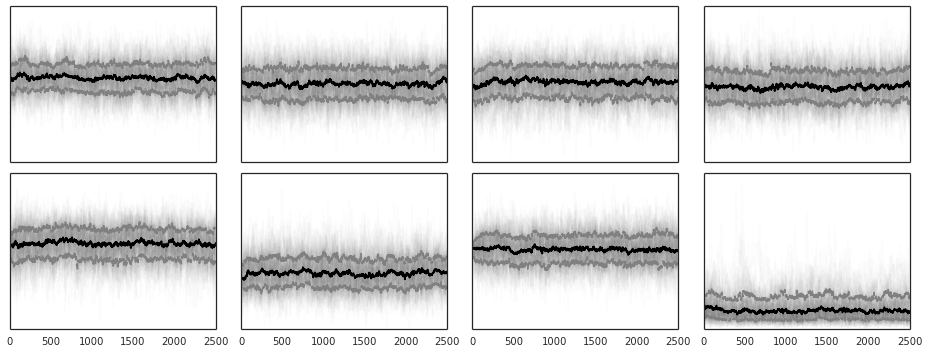

In [7]:
with sb.axes_style('white'):
    fig, axs = subplots(2,4, figsize=(13,5), sharex=True)
    ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
    percs = [percentile(sampler.chain[:,:,i], [50,16,84], 0) for i in range(8)]
    [axs.flat[i].plot(sampler.chain[:,:,i].T, 'k', alpha=0.01) for i in range(8)]
    [[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(8)]
    setp(axs, yticks=[], xlim=[0,mc_iter])
    fig.tight_layout()

Ok, everything looks good. The 16th, 50th and 84th percentiles of the parameter vector population stabilise rapidly, and they don't show any significant long-term trends.

Next, we want to check the mean autocorrelation length for each parameter in order to decide a suitable MCMC chain *thinning factor*. This needs to be done because the consecutive MCMC samples are correlated, and we want a set of independent samples.  The *emcee* sampler offers a method for this if the ``acor`` module is installed.

In [8]:
sampler.acor.astype(np.int)

array([69, 55, 68, 64, 68, 64, 61, 75, 79])

We can select a thinning factor of 75 and a burn-in time of 400 based on visual inspection of the chain population and the estimated autocorrelation length. Note that this isn't a very rigorous way of selecting these values, and you well might want to do some additional tests for a more serious analysis. 

With the thinning and burn-in values set, we can also flatten the chains, and calculate the median parameter vector.

In [9]:
thin = 75
burn = 400

fc = sampler.chain[:,burn::thin,:].reshape([-1,sampler.chain.shape[-1]])
mp = median(fc, 0)

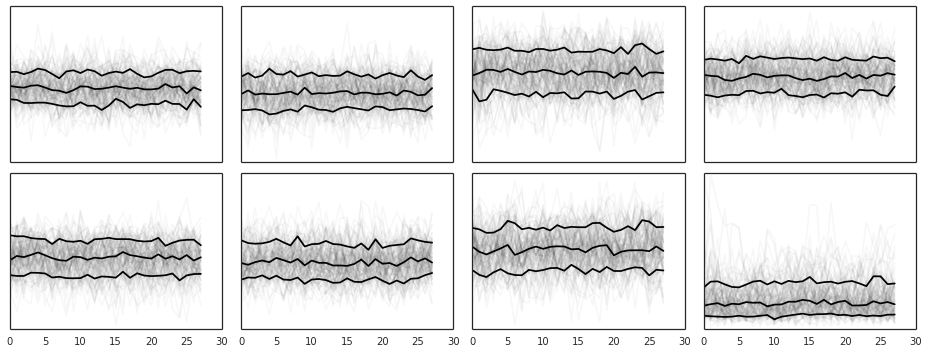

In [10]:
with sb.axes_style('white'):
    fig, axs = subplots(2,4, figsize=(13,5), sharex=True)
    percs = [percentile(sampler.chain[:,burn::thin,i], [50,16,84], 0) for i in range(8)]
    [axs.flat[i].plot(sampler.chain[:,burn::thin,i].T, 'k', alpha=0.03) for i in range(8)]
    [[axs.flat[i].plot(percs[i][j], 'k') for j in range(3)] for i in range(8)]
    setp(axs, yticks=[])
    fig.tight_layout()

Let's also plot the model and the data to see if this all makes sense. To do this, we calculate the conditional distribution of flux using the posterior samples (here, we're using a random subset of samples, although this isn't really necessary), and plot the distribution median and it's median-centred 68%, 95%, and 99.7% central posterior intervals (corresponding approximately to 1, 2, and 3$\sigma$ intervals if the distribution is normal). 

In [11]:
flux_pr = array([lpf.compute_lc_model(pv) for pv in fc[permutation(fc.shape[0])[:1000]]])
flux_pc = array(percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))

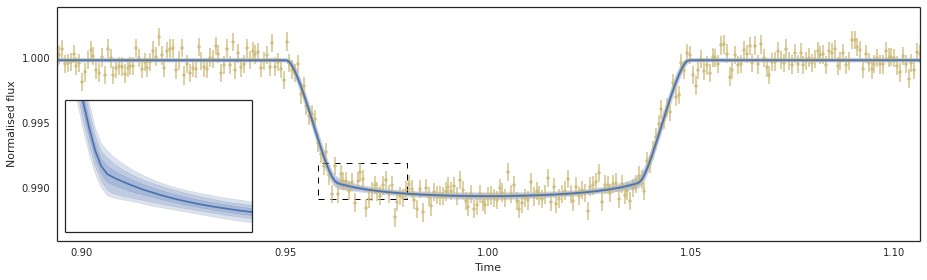

In [12]:
with sb.axes_style('white'):
    zx1,zx2,zy1,zy2 = 0.958,0.98, 0.9892, 0.992
    fig, ax = subplots(1,1, figsize=(13,4))
    cp = sb.color_palette()
    ax.errorbar(lpf.time, lpf.flux_o, mp[5], fmt='.', c=cp[4], alpha=0.75)
    [ax.fill_between(lpf.time,*flux_pc[i:i+2,:],alpha=0.2,facecolor=cp[0]) for i in range(1,6,2)]
    ax.plot(lpf.time, flux_pc[0], c=cp[0])
    setp(ax, xlim=lpf.time[[0,-1]], xlabel='Time', ylabel='Normalised flux')
    fig.tight_layout()
    
    az = fig.add_axes([0.075,0.18,0.20,0.46])
    ax.add_patch(Rectangle((zx1,zy1),zx2-zx1,zy2-zy1,fill=False,edgecolor='k',lw=1,ls='dashed'))
    [az.fill_between(lpf.time,*flux_pc[i:i+2,:],alpha=0.2,facecolor=cp[0]) for i in range(1,6,2)]
    setp(az, xlim=(zx1,zx2), ylim=(zy1,zy2), yticks=[], xticks=[])
    az.plot(lpf.time, flux_pc[0], c=cp[0])

We could (should) also plot the residuals, but I've left them out from the plot for clarity. The plot looks fine, and we can continue to have a look at the parameter estimates.

## Analysis

We start the analysis by making a Pandas data frame ``df``, using the ``df.describe`` to gen an overview of the estimates, and plotting the posteriors for the most interesting parameters as violin plots.

In [13]:
pd.set_option('display.precision',4)
df = pd.DataFrame(data=fc.copy(), columns=lpf.ps.names)
df['e'] *= 1e6
df['k'] = sqrt(df.k2)
df['u'] = 2*sqrt(df.q1)*df.q2
df['v'] = sqrt(df.q1)*(1-2*df.q2)
df = df.drop('k2', axis=1)
df.describe()

,tc,p,rho,b,e,c,q1,q2,k,u,v
count,2800.000,2800.000,2800.000,2800.000,2800.000,2.800e+03,2800.000,2.800e+03,2800.000,2.800e+03,2800.000
mean,1.000,2.500,1.486,0.514,707.673,9.999e-01,0.067,3.562e-01,0.100,1.491e-01,0.098
std,0.000,0.010,0.080,0.029,29.356,5.626e-05,0.042,2.712e-01,0.001,9.678e-02,0.146
min,0.999,2.463,1.200,0.407,624.122,9.997e-01,0.004,7.440e-05,0.098,4.665e-05,-0.232
25%,1.000,2.493,1.431,0.494,687.036,9.999e-01,0.036,1.226e-01,0.100,6.773e-02,-0.020
50%,1.000,2.500,1.486,0.515,706.349,9.999e-01,0.057,2.998e-01,0.100,1.398e-01,0.097
75%,1.000,2.507,1.539,0.535,726.939,9.999e-01,0.089,5.455e-01,0.101,2.230e-01,0.210
max,1.000,2.540,1.772,0.610,806.095,1.000e+00,0.345,9.987e-01,0.102,4.895e-01,0.565


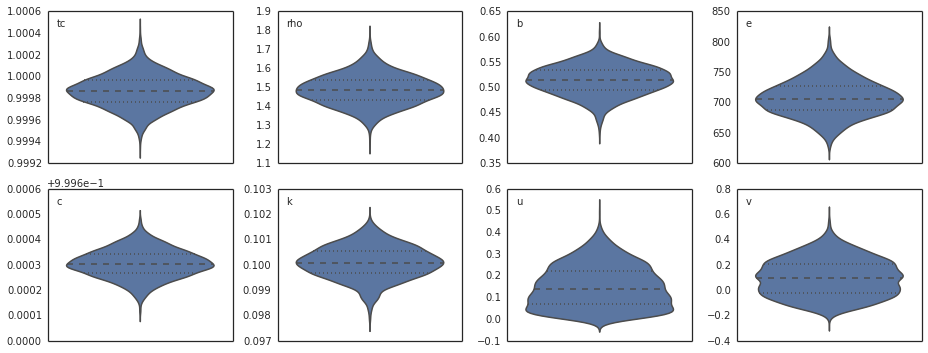

In [14]:
with sb.axes_style('white'):
    fig, axs = subplots(2,4, figsize=(13,5))
    pars = 'tc rho b e c k u v'.split()
    [sb.violinplot(df[p], ax=axs.flat[i]) for i,p in enumerate(pars)]
    [axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(pars)]
    setp(axs, xticks=[], ylabel='')
    fig.tight_layout()

While we're at it, let's plot some correlation plots. The limb darkening coefficients are correlated, and we'd also expect to see a correlation between the impact parameter and radius ratio.

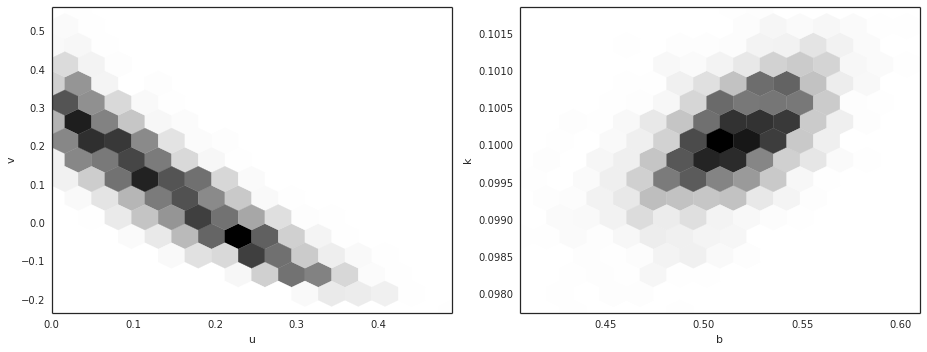

In [15]:
with sb.axes_style('white'):
    fig, axs = subplots(1,2, figsize=(13,5))
    cpars = dict(gridsize=15)
    axs[0].hexbin(df.u,df.v, **cpars)
    axs[1].hexbin(df.b,df.k, **cpars)
    setp(axs[0], xlabel='u', ylabel='v')
    setp(axs[1], xlabel='b', ylabel='k')
    fig.tight_layout()

## Calculating the parameter estimates for all the filters

Ok, now, let's do the parameter estimation for all the filters. We wouldn't be doing separate per-filter parameter estimation in real life, since it's much better use of the data to do a simultaneous joint modelling of all the data together (this is something that will be shown in a later tutorial). This will take some time...

In [17]:
chains = []
npop, de_iter, mc_iter, burn, thin = 100, 200, 1500, 400, 75
pb = IntProgressWidget(max=len(fluxes))
display(pb)
for flux in fluxes:
    lpf = LPFunction(time, flux)
    de = DiffEvol(lpf, lpf.ps.bounds, npop, maximize=True)
    sampler = EnsembleSampler(npop, lpf.ps.ndim, lpf)
    de.optimize(de_iter)
    sampler.run_mcmc(de.population, mc_iter)
    chains.append(sampler.chain[:,burn::thin,:].reshape([-1,sampler.chain.shape[-1]]))
    pb.value += 1
chains = array(chains)

In [18]:
ids = [repeat(filter_names,chains.shape[1]),8*range(chains.shape[1])]
dft = pd.DataFrame(data = concatenate([chains[i,:,:] for i in range(chains.shape[0])]), 
                   index=ids, columns=lpf.ps.names)
dft['e'] *= 1e6
dft['k'] = sqrt(dft.k2)
dft['u'] = 2*sqrt(dft.q1)*dft.q2
dft['v'] = sqrt(dft.q1)*(1-2*dft.q2)
dft = dft.drop('k2', axis=1)

In [19]:
dft.ix['u'].describe()

,tc,p,rho,b,e,c,q1,q2,k,u,v
count,1500.000,1500.000,1500.000,1500.000,1500.000,1.500e+03,1500.000,1500.000,1500.000,1500.000,1500.000
mean,1.000,2.500,1.529,0.499,752.028,1.000e+00,0.652,0.594,0.100,0.916,-0.116
std,0.000,0.010,0.090,0.039,31.634,5.803e-05,0.184,0.165,0.002,0.135,0.232
min,1.000,2.464,1.232,0.341,663.427,9.998e-01,0.280,0.232,0.093,0.463,-0.642
25%,1.000,2.493,1.465,0.476,730.710,9.999e-01,0.498,0.462,0.099,0.818,-0.294
50%,1.000,2.500,1.527,0.503,749.800,1.000e+00,0.635,0.565,0.100,0.912,-0.104
75%,1.000,2.507,1.589,0.527,772.160,1.000e+00,0.801,0.705,0.101,1.010,0.069
max,1.001,2.536,1.882,0.613,863.987,1.000e+00,1.000,0.999,0.106,1.302,0.535


The dataframe creation can probably be done in a nicer way, but we don't need to bother with that. The results are now in a multi-index dataframe, from where we can easily get the per-filter point estimates. 

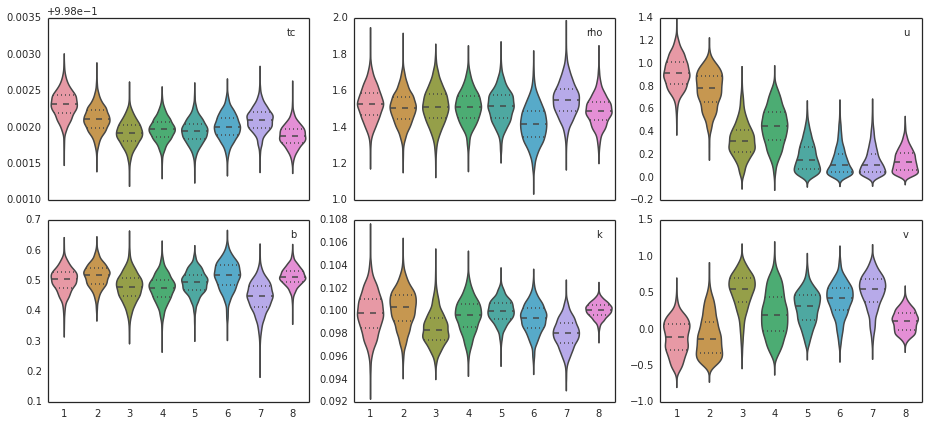

In [20]:
with sb.axes_style('white'):
    fig, axs = subplots(2,3, figsize=(13,6), sharex=True)
    pars = 'tc rho u b k v'.split()
    for i,p in enumerate(pars):
        sb.violinplot([dft[p][f] for f in filter_names], ax=axs.flat[i])
        axs.flat[i].text(0.95,0.9, p, transform=axs.flat[i].transAxes, ha='right')
    fig.tight_layout()

As it is, the posterior distributions for different filters agree well with each other. However, the uncertainty in the radius ratio estimate decreases towards redder wavelengths. This is due to the reduced limb darkening, which allows us to estimate the true geometric radius ratio more accurately.

Finally, let's print the parameter estimates for each filter. We'll print the posterior medians with uncertainty estimates based on the central 68% posterior intervals. This matches the posterior mean and its 1-$\sigma$ uncertainty if the posterior is normal (which isn't really the case for many of the posteriors here). In real life, you'd want to report separate + and - uncertainties for the asymmetric posteriors, etc.

In [21]:
def ms(df,p,f):
    p = array(percentile(df[p][f], [50,16,84]))
    return p[0], abs(p[1:]-p[0]).mean()

def create_row(df,f,pars):
    return ('<tr><td>{:}</td>'.format(f)+
            ''.join(['<td>{:5.4f} &plusmn; {:5.4f}</td>'.format(*ms(dft,p,f)) for p in pars])+
            '</tr>')

def create_table(df):    
    pars = 'tc rho b k u v'.split()
    return ('<table style="width:100%"><th>Filter</th>'+
            ''.join(['<th>{:}</th>'.format(p) for p in pars])+
            ''.join([create_row(df,f,pars) for f in filter_names])+
            '</table>')

In [22]:
display(HTML(create_table(dft)))

u,1.0003 ± 0.0002,1.5271 ± 0.0918,0.5030 ± 0.0383,0.0998 ± 0.0019,0.9116 ± 0.1416,-0.1044 ± 0.2509
g,1.0001 ± 0.0002,1.5041 ± 0.0871,0.5172 ± 0.0368,0.1003 ± 0.0017,0.7795 ± 0.1705,-0.1321 ± 0.3057
r,0.9999 ± 0.0002,1.5117 ± 0.0989,0.4793 ± 0.0456,0.0983 ± 0.0014,0.3142 ± 0.1460,0.5542 ± 0.2390
i,1.0000 ± 0.0002,1.5101 ± 0.0871,0.4760 ± 0.0430,0.0997 ± 0.0015,0.4476 ± 0.1838,0.1908 ± 0.3346
z,0.9999 ± 0.0002,1.5139 ± 0.0869,0.4931 ± 0.0380,0.1000 ± 0.0010,0.1524 ± 0.1328,0.3123 ± 0.2338
J2,1.0000 ± 0.0002,1.4154 ± 0.1025,0.5177 ± 0.0469,0.0994 ± 0.0013,0.1063 ± 0.1162,0.4206 ± 0.2280
H2,1.0001 ± 0.0002,1.5483 ± 0.0935,0.4482 ± 0.0483,0.0980 ± 0.0013,0.1039 ± 0.1129,0.5423 ± 0.2354
Ks,0.9999 ± 0.0001,1.4890 ± 0.0794,0.5117 ± 0.0285,0.1001 ± 0.0006,0.1304 ± 0.1028,0.1111 ± 0.1599


---
<center>&copy; Hannu Parviainen 2014--2015</center>